In [2]:
from google.colab.patches import cv2_imshow
import csv
import random
import time
import pandas as pd
import matplotlib.image as mping
import matplotlib.pyplot as plt
import seaborn as sns
from keras import optimizers
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import RMSprop
from keras import utils as np_utils
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import os
import zipfile


# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path)
    zf.extractall()


if __name__ == '__main__':
    file_path = '/content/drive/MyDrive/ICTS.zip'
    zip_list(file_path)


In [3]:
img = glob.glob('/content/image/*')
label = glob.glob('/content/label/*')

print(len(img))
print(len(label))

1500
1500


In [5]:
images = []

for f in range(len(img)):
    a = nib.load(img[f])
    a = a.get_data()
    
for i in range(a.shape[1]):
    images.append((a[:,i,:]))

print (a.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


(512, 512, 86)


In [6]:

labels = []

for c in range(len(label)):
    la = nib.load(label[c])
    la = la.get_data()
    
for d in range(la.shape[1]):
    labels.append((la[:,d,:]))
  
print (la.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


(512, 512, 86)


In [7]:
images = np.asarray(images)
print(images.shape)
labels = np.asarray(labels)
print(labels.shape)

(512, 512, 86)
(512, 512, 86)


In [8]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                labels,
                                test_size=0.2,
                                random_state=13)

print(train_X.shape)
print(train_ground.shape)

(409, 512, 86)
(409, 512, 86)


In [54]:
batch_size = 100
epochs = 10
inChannel = 1
x, y = 512, 86
input_img = Input(shape = (x, y, inChannel))

In [61]:
def autoencoder(input_img):
    #encoder
    #input = 512 x 86 x 1 (wide and thin)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #512 x 86 x 16
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #256 x 43 x 32
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) #256 x 43 x 64
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(1, 1), padding='valid')(conv2) #256 x 43 x 64
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) #256 x 43 x 64 (small and thick)
    conv3 = BatchNormalization()(conv3)
   

    #decoder
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3) #256 x 43 x 32
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 512 x 86 x 32
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) # 512 x 86 x 16
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((1,1))(conv5) # 512 x 86 x 16
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 512 x 86 x 1
    return decoded

In [62]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy'])
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 86, 1)]      0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 512, 86, 16)       160       
_________________________________________________________________
batch_normalization_135 (Bat (None, 512, 86, 16)       64        
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 256, 43, 16)       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 256, 43, 32)       4640      
_________________________________________________________________
batch_normalization_136 (Bat (None, 256, 43, 32)       128       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 256, 43, 32)       0  

In [63]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/10
5/5 [==============================] - 107s 20s/step - loss: 0.2738 - accuracy: 0.5220 - val_loss: 0.4399 - val_accuracy: 0.6891
Epoch 2/10
5/5 [==============================] - 104s 20s/step - loss: 0.1985 - accuracy: 0.8435 - val_loss: 0.4309 - val_accuracy: 0.7037
Epoch 3/10
5/5 [==============================] - 104s 20s/step - loss: 0.1720 - accuracy: 0.8817 - val_loss: 0.3818 - val_accuracy: 0.7166
Epoch 4/10
5/5 [==============================] - 103s 20s/step - loss: 0.1547 - accuracy: 0.8890 - val_loss: 0.3578 - val_accuracy: 0.7224
Epoch 5/10
5/5 [==============================] - 101s 19s/step - loss: 0.1389 - accuracy: 0.9010 - val_loss: 0.3491 - val_accuracy: 0.7316
Epoch 6/10
5/5 [==============================] - 103s 20s/step - loss: 0.1224 - accuracy: 0.9245 - val_loss: 0.3252 - val_accuracy: 0.7352
Epoch 7/10
5/5 [==============================] - 107s 21s/step - loss: 0.1147 - accuracy: 0.9264 - val_loss: 0.3072 - val_accuracy: 0.7402
Epoch 8/10
5/5 [====

In [110]:
import os
import zipfile

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path)
    zf.extractall()

if __name__ == '__main__':
    file_path = '/content/drive/MyDrive/ICTS-test-2020.zip'
    zip_list(file_path)


In [113]:
testimg = glob.glob('/content/imagtest/*')

testimages = []

for f in range(len(testimg)):
    a = nib.load(testimg[f])
    a = a.get_data()
    
for i in range(a.shape[1]):
    testimages.append((a[:,i,:]))

print(a.shape)

testimages = np.asarray(testimages)
print(testimages.shape)
print(len(testimg))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys


(512, 512, 86)
(512, 512, 86)
91


In [120]:
y_pred_keras = autoencoder.predict_generator(testimages, verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16/16 [==============================] - 27s 2s/step


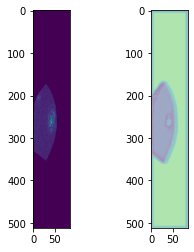

In [121]:
plt.subplot(1,3,1)
plt.imshow(testimages[100])

plt.subplot(1,3,2)
plt.imshow(y_pred_keras[100][...,0],alpha = 0.5)